## Project 2 milestone, CS-401 : Applied data analysis, group : theAvengers

#### import useful libraries and python files

In [1]:
import pandas as pd
import numpy as np
import json
import sys
import requests
import re

from data_loader import *
%load_ext autoreload
%autoreload 2

Lets first download our datasets and  extract the former countriers, the genres and the languages from each movie and create new columns feature that will be able to access more easily on the mentionned datas.

In [2]:
#loading the datasets
dataFrame_movie = load_cmu_movies()
dataFrame_character = load_cmu_characters()
#dataFrame_kaggle_movie = load_kaggle_movies()

#extracting the aforementioned features
dataFrame_movie['Country_List'] = dataFrame_movie['Countries'].apply(extract_features_names)
dataFrame_movie['Genre_List'] = dataFrame_movie['Genres'].apply(extract_features_names)
dataFrame_movie['Language_List'] = dataFrame_movie['Language'].apply(extract_features_names)

We decided to add additional datasets in order to complete our datas. However, trying to merge those datasets based on their Movies names doesn't work as there are movies that have the same Name but are in fact different. Therefore, it is complicated to differentiate movies based on their names. To overcome this issue, we identified each movie by its Freebase ID or its IMDB ID (depending on the dataset). To do so, we first need to retreive the IMDB ID (i.e. tconst column) based on the movie's Freebase ID. The code to do this can be retreive below but it has been put in comments as the file generated contains data directly retreive from the wiki-data and therefore may vary over time (if I run the below function in few days, I could have more or less rows)

In [3]:

#df_id_translation = get_wikidata_id_translations()
#display(df_id_translation)

#save the dataframe to a JSON file
#df_id_translation.to_json('id-translation.wikidata.json', orient='records', lines=True)

Instead, we can load a file that has been already generate by the above function "get_wikidata_id_translations()" :

In [4]:
#replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

#load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

#display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm3628633,/m/0k83_1r
1,nm0012078,/m/02q173g
2,nm0394250,/m/03kfdk
3,tt0324924,/m/0ct2z8
4,nm0119354,/m/0356cy
...,...,...
990453,tt29521500,None
990454,nm2106941,None
990455,nm2186144,None
990456,nm4531538,None


Then, we can drop Nan and duplicates values and merge it with the CMU movies dataset 

In [5]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

dataFrame_movie = pd.merge(dataFrame_movie, df_id_translation, on='Freebase ID', how='left')
display(dataFrame_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Revenue,Run Time,Language,Countries,Genres,Year,Month,Day,Country_List,Genre_List,Language_List,tconst
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],tt0245916
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,[Norway],"[Crime Fiction, Drama]",[Norwegian Language],tt0094806
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[English Language],tt0094320
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,[Germany],[Drama],[German Language],tt0083949
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,5,29,[United States of America],"[Short Film, Silent film, Indie, Comedy]","[Silent film, English Language]",tt0002894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81735,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,[United States of America],[Drama],[English Language],tt1816585
81736,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",[English Language],tt1606259
81737,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,[United States of America],"[Satire, Comedy]",[English Language],tt0362411
81738,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",[Japanese Language],tt0113726


In [6]:
#compute percentage of missing values for df_movie
percentage_missing_values_year = (dataFrame_movie['Year'].isna().sum()/len(dataFrame_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (dataFrame_movie['Month'].isna().sum()/len(dataFrame_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

#percentage_missing_values_runtime = (dataFrame_movie['Runtime'].isna().sum()/len(dataFrame_movie['Runtime']))*100
#print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (dataFrame_movie['tconst'].isna().sum()/len(dataFrame_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")

The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.833%.
The percentage of missing values 'Box office' is 89.724%.
The percentage of missing values 'tconst' is 9.769%.


### Load addtionnal datasets and merge what we need 

In [7]:
#load imdb dataset (from kaggle)
dataFrame_imdb_movie = load_movie_imdb_kaggle()
dataFrame_imdb_rating = load_rating_imdb_kaggle() 

In [8]:
#merge movies with rating 
df_movie_rating = pd.merge(dataFrame_imdb_movie, dataFrame_imdb_rating, on='tconst', how='inner')
display(df_movie_rating)

,tconst,titleType,Name,originalTitle,isAdult,Year,endYear,Runtime,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100.0,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Action,Adventure,Biography",6.0,854
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90.0,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299375,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84.0,Thriller,5.8,1446
299376,tt9916362,movie,Coven,Akelarre,0,2020,\N,92.0,"Drama,History",6.4,5600
299377,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,NaN,"Adventure,History,War",3.5,17
299378,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123.0,Drama,8.6,7


In [9]:
#merge CMU dataset with IMDB dataset
dataFrame_movie = pd.merge(dataFrame_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
display(dataFrame_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Revenue,Run Time,Language,Countries,Genres,Year,Month,Day,Country_List,Genre_List,Language_List,tconst,averageRating,numVotes
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],tt0245916,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,[Norway],"[Crime Fiction, Drama]",[Norwegian Language],tt0094806,5.6,40.0
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[English Language],tt0094320,6.1,2888.0
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,[Germany],[Drama],[German Language],tt0083949,6.0,621.0
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,5,29,[United States of America],"[Short Film, Silent film, Indie, Comedy]","[Silent film, English Language]",tt0002894,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81735,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,[United States of America],[Drama],[English Language],tt1816585,NaN,NaN
81736,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",[English Language],tt1606259,6.8,3191.0
81737,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,[United States of America],"[Satire, Comedy]",[English Language],tt0362411,5.8,110.0
81738,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",[Japanese Language],tt0113726,NaN,NaN


In [10]:
#load kaggle movies dataset
dataFrame_kaggle_movie = load_kaggle_movies()

In [11]:
#merging the two datasets
dataFrame_movie = dataFrame_movie.merge(dataFrame_kaggle_movie[['Name', 'tconst', 'Revenue']], on=['Name', 'tconst'], how='left', suffixes=('', '_df2'))

#use 'combine_first' to fill in the 'Revenue' values from df_kaggle_movie where they are NaN in df_movie
dataFrame_movie['Revenue'] = dataFrame_movie['Revenue'].combine_first(dataFrame_movie['Revenue_df2'])

#drop the 'Revenue_df2' column
dataFrame_movie.drop('Revenue_df2', axis=1, inplace=True)

#drop duplicates
dataFrame_movie = dataFrame_movie.drop_duplicates(subset='Wikipedia ID', keep='first')
display(dataFrame_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Revenue,Run Time,Language,Countries,Genres,Year,Month,Day,Country_List,Genre_List,Language_List,tconst,averageRating,numVotes
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],tt0245916,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,[Norway],"[Crime Fiction, Drama]",[Norwegian Language],tt0094806,5.6,40.0
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[English Language],tt0094320,6.1,2888.0
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,[Germany],[Drama],[German Language],tt0083949,6.0,621.0
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,5,29,[United States of America],"[Short Film, Silent film, Indie, Comedy]","[Silent film, English Language]",tt0002894,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,[United States of America],[Drama],[English Language],tt1816585,NaN,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,0.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",[English Language],tt1606259,6.8,3191.0
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,[United States of America],"[Satire, Comedy]",[English Language],tt0362411,5.8,110.0
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",[Japanese Language],tt0113726,NaN,NaN


In [12]:
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_movie['averageRating'].isna().sum()/len(dataFrame_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")


The percentage of missing values 'Revenue' is 70.124%.
The percentage of missing values 'averageRating' is 31.271%.


The additional dataset allow us to enhance our dataframe. We have a second metric, the average Rating of film, which could also be used.

### Description of Revenue and Average Ratings:

In [13]:
# Conduct some First Descriptive Analysis on the Revenue and Ratings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy

In [14]:
dataFrame_movie = copy.deepcopy(dataFrame_movie)

In [15]:
#Remove observation with Nan and infs 
#create a temporary dataframe dataFrame_movie_new for describing the data 
dataFrame_movie_new = dataFrame_movie 
dataFrame_movie_new = dataFrame_movie_new[dataFrame_movie_new['Revenue'] >= 10]
dataFrame_movie_new['Revenue'] = dataFrame_movie_new['Revenue'].dropna()
dataFrame_movie_new['averageRating'] = dataFrame_movie_new['averageRating'].dropna()
dataFrame_movie_new['Year'] = dataFrame_movie_new['Year'].dropna()

/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/2189607934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_movie_new['Revenue'] = dataFrame_movie_new['Revenue'].dropna()
/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/2189607934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_movie_new['averageRating'] = dataFrame_movie_new['averageRating'].dropna()
/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/2189607934.py:7: SettingWithCopyW

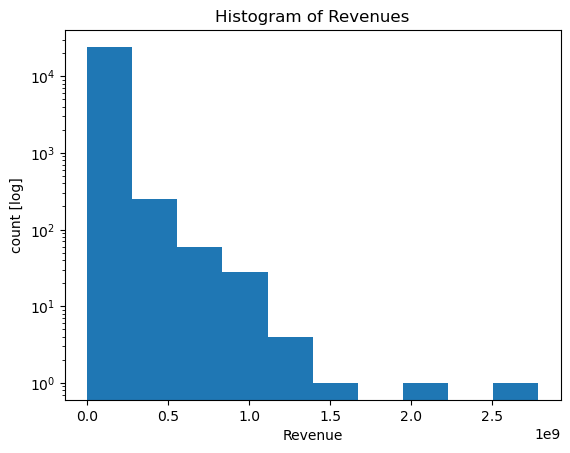

In [16]:
# Distribution of Revenues
#scales are very high on the x axis so we are gonna plot log(x) against y
dataFrame_movie['Revenue'].plot(kind='hist', logy=True)
plt.xlabel('Revenue')
plt.ylabel('count [log]')
plt.title('Histogram of Revenues')
plt.show()


In [17]:
# Descriptive statistics for Revenue:
dataFrame_movie['Revenue'].describe()

count    2.442100e+04
mean     1.831671e+07
std      7.398546e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.028293e+06
max      2.782275e+09
Name: Revenue, dtype: float64

In [18]:
# Evolution of revenues during time 

df = dataFrame_movie_new[['Year','Revenue']].groupby(['Year']).mean()
df['std'] = dataFrame_movie_new[['Year','Revenue']].groupby(['Year']).std()
df['Year']=df.index
#drop first value 
df = df[df['Year'] > 1900]

df.replace([np.inf, -np.inf, np.isfinite], np.nan, inplace=True)  # Replace inf with NaN
df = df.dropna()  # Drop rows with NaN or inf


Text(0, 0.5, 'Revenue')

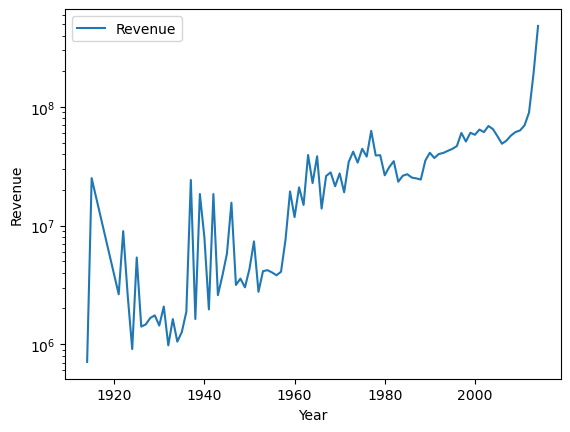

In [19]:
#plot 
df.plot(x = 'Year', y='Revenue', logy= True)
plt.xlabel('Year')
plt.ylabel('Revenue')

In [20]:
#Revenue according to coutry
dataFrame_movie_new['Country_List'] = dataFrame_movie_new['Country_List'].apply(tuple)
df1 = dataFrame_movie_new[['Revenue','Country_List']].groupby(['Country_List']).mean()
df1['Country_List']= df1.index
df1 = df1[df1['Revenue'] > 1e+08]


/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/974361500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_movie_new['Country_List'] = dataFrame_movie_new['Country_List'].apply(tuple)


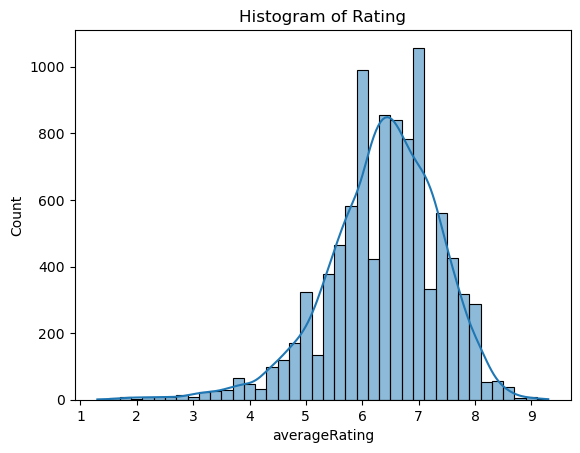

In [21]:
# Distribution of Average Ratings
sns.histplot(data=dataFrame_movie_new, x='averageRating', bins=40, kde = True)
plt.title('Histogram of Rating')
plt.show()


In [22]:
#Descriptive data for the Average Rating
dataFrame_movie_new['averageRating'].describe()

count    9581.000000
mean        6.369909
std         0.997123
min         1.300000
25%         5.800000
50%         6.400000
75%         7.100000
max         9.300000
Name: averageRating, dtype: float64

In [23]:
# Evolution of ratings during time 
df2 = dataFrame_movie_new[['Year','averageRating']].groupby(['Year']).mean()
df2['std'] = dataFrame_movie_new[['Year','averageRating']].groupby(['Year']).std()
df2['Year']=df2.index
df2 = df2[df2['Year'] > 1900]

Text(0, 0.5, 'averageRating')

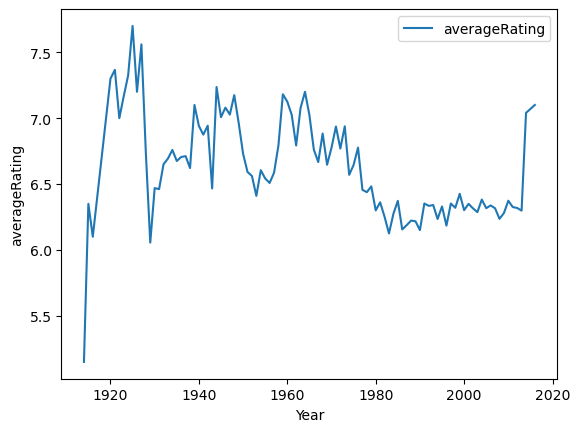

In [24]:
# plot of the Evolution of average rating
df2.plot(x = 'Year', y='averageRating')
plt.xlabel('Year')
plt.ylabel('averageRating')

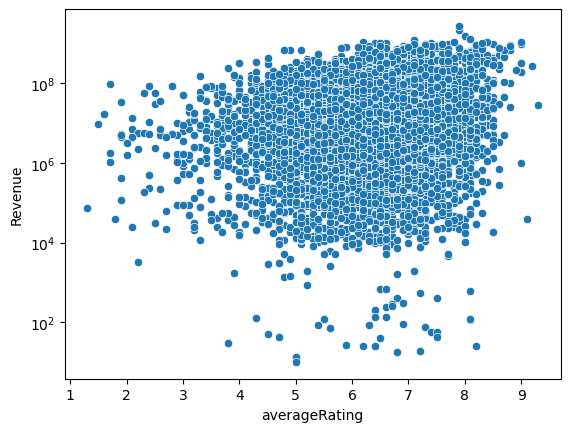

In [25]:
# Correlation between Revenue and averageRating
sns.scatterplot(data=dataFrame_movie_new,x='averageRating',y='Revenue')
plt.yscale('log')

/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/69930538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_movie_new['Revenue'] = np.log(dataFrame_movie_new['Revenue'])


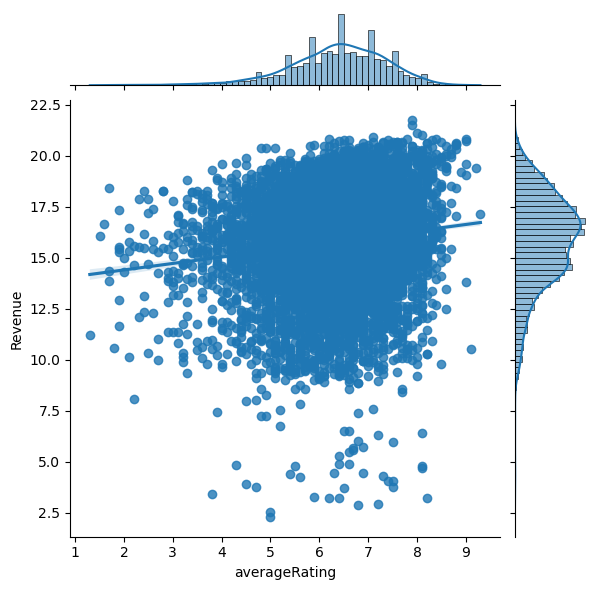

In [26]:
dataFrame_movie_new['Revenue'] = np.log(dataFrame_movie_new['Revenue'])
sns.jointplot(x=dataFrame_movie_new['averageRating'], y=dataFrame_movie_new['Revenue'], kind="reg")#kde,reg also

In [27]:
# Pearson correlation 
dataFrame_movie_new.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
dataFrame_movie_new = dataFrame_movie_new.dropna()  # Drop rows with NaN or inf
stats.pearsonr(dataFrame_movie_new['averageRating'],dataFrame_movie_new['Revenue']) 

/var/folders/bn/ds_wr8111z3c4d9rq_nhk1dw0000gn/T/ipykernel_54919/2525849065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_movie_new.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN


PearsonRResult(statistic=0.14459127725179782, pvalue=2.1024906156393303e-36)

In [28]:
# Pearson correlation when we group by year
df2['Revenue']= dataFrame_movie_new[['Year','Revenue']].groupby(['Year']).mean()['Revenue']
df2.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df2 = df2.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df2['averageRating'],df2['Revenue'])  

PearsonRResult(statistic=-0.24251517415701915, pvalue=0.01851847942001943)

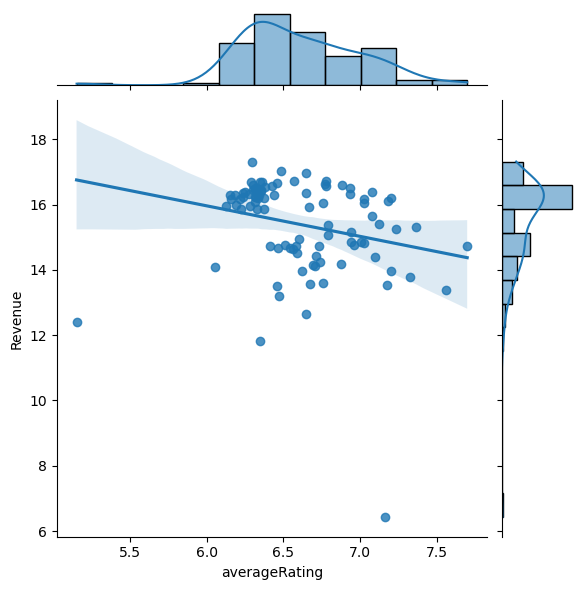

In [29]:
sns.jointplot(x=df2['averageRating'], y=df2['Revenue'], kind="reg")

In [30]:
# Pearson correlation when we group by Country
df3 = dataFrame_movie_new[['Revenue','Country_List']].groupby(['Country_List']).mean()
df3['averageRating']= dataFrame_movie_new[['averageRating','Country_List']].groupby(['Country_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue'])  

PearsonRResult(statistic=-0.05269012298390791, pvalue=0.23910111199400635)

In [31]:
# Pearson correlation when we group by Language
dataFrame_movie_new['Language_List'] = dataFrame_movie_new['Language_List'].apply(tuple)
df3 = dataFrame_movie_new[['Revenue','Language_List']].groupby(['Language_List']).mean()
df3['averageRating']= dataFrame_movie_new[['averageRating','Language_List']].groupby(['Language_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue']) 

PearsonRResult(statistic=0.0023443656700654564, pvalue=0.9546086049139713)

## Let's start with the analysis

Now that we have now our 2 dataframes. First, We will drop the NA in the revenue. We need to have the revenues of the movie we are working with. 

In [32]:
dataFrame_movie = dataFrame_movie.dropna(subset=['Revenue'])

First, we are counting the number of actor per film (actor = character) 

In [33]:
df_count = dataFrame_movie.merge(dataFrame_character, on = 'Wikipedia ID', how = 'left') # POPULATE EACH MOVIE WITH ACTOR 
counter = df_count.groupby('Wikipedia ID')['Actor Name'].nunique() # We count the number of actor per movie

In [34]:
df_count

,Wikipedia ID,Freebase ID_x,Name,Release date_x,Revenue,Run Time,Language,Countries,Genres,Year,...,Character Name,Actor Birth,Actor Gender,Actor Height,Ethnicity,Actor Name,Actor Age At Movie Release,Freebase Actor/Character Map ID,Freebase Character ID,Freebase Actor ID
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,NaN,1908-01-16,F,NaN,NaN,Ethel Merman,30.0,/m/02vctvm,NaN,/m/0pkw7
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,Roger Grant AKA Alexander,1914-05-05,M,1.820,/m/06v41q,Tyrone Power,24.0,/m/02vbvj2,/m/0h36wrs,/m/02s58t
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,NaN,1915-05-05,F,1.650,/m/033tf_,Alice Faye,23.0,/m/02vbq8t,NaN,/m/032xfz
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,NaN,1908-05-31,M,1.791,NaN,Don Ameche,30.0,/m/02vbjy4,NaN,/m/02l0xc
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,Henry V,1960-12-10,M,1.770,/m/0d7wh,Kenneth Branagh,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227712,23851782,/m/06_vb43,The Ghost Train,1941-05-03,0.0,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1941,...,NaN,1900-01-14,M,NaN,NaN,Wilfrid Lawson,41.0,/m/0gcgrfv,NaN,/m/025w40r
227713,23851782,/m/06_vb43,The Ghost Train,1941-05-03,0.0,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1941,...,NaN,1891-08-08,M,NaN,NaN,Morland Graham,NaN,/m/0gckksz,NaN,/m/0gc08qy
227714,23851782,/m/06_vb43,The Ghost Train,1941-05-03,0.0,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1941,...,NaN,1869,M,NaN,NaN,D.J. Williams,NaN,/m/0gdk36r,NaN,/m/0gcwx9k
227715,12095128,/m/02vppbd,My Love,NaN,0.0,26.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/06bnz"": ""Russia""}","{""/m/02hmvc"": ""Short Film""}",<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import matplotlib.pyplot as plt


plt.hist(counter, bins =max(counter))

plt.title('Frequency of the Number of actor per movie')
plt.xlabel('Number of actor per movie')
plt.ylabel('Frequency')
plt.show()


Now, the idea is to create a matrix. Each row of the matrix represent a differente movie. Every Column represents a different actor. The matrix returns 1 if the actor i plays in the movie j and 0 otherwise

In [36]:
# Create a binary matrix where rows represent movies, columns represent actors
binary_matrix = df_count.pivot_table(index='Name', columns='Actor Name', aggfunc='size', fill_value=0)

# Reset the index to have movie name as a column
binary_matrix = binary_matrix.reset_index()

# Fill NaN values with 0
binary_matrix = binary_matrix.fillna(0)


binary_matrix.columns = ['Name'] + [ str(col) for col in binary_matrix.columns[1:]]

# Set 'movie name' as the index 
binary_matrix.set_index('Name', inplace=True)

KeyboardInterrupt: 

In [ ]:
binary_matrix

We have to much actor right now, therefore we have to get rid of many of them

Using this matrix, we will remove the actors that appears in less than 35 movies. This number (35) is now arbitrary (at this time of the analysis). We are just trying to have a look if there is enough data (here data = actor) useful for regression.

In [ ]:
#Create the binary matrix
actor_sum=binary_matrix.sum()
# Create a mask
actors_to_drop=actor_sum[actor_sum<35].index

In [ ]:
# Drop the actor that have not enough movies
filtered_binary_matrix=binary_matrix.drop(actors_to_drop,axis=1)

In [ ]:
filtered_binary_matrix  

In [ ]:
# Print the actor 
for i in filtered_binary_matrix.columns.tolist():
    print(i)

Even with this filter, we still have a high number of actor (113). This is still a high number and if we want to test every pair of actor as a independant variable, we need (113*112)/2 beta. We still have the possibility to filter more using maybe more qualitative aspect. 

An important aspect that we have to care about is the interaction between actors. We build now the matrix of interraction between actors with more than 25 films. (Why 25? because it is better to have a bigger number of actor) Again, this number is arbitrary but using more actor for this interaction matrix is intresting to filter on more qualitative aspect.

In [ ]:
# Same methodology as before
actors_to_drop=actor_sum[actor_sum<25].index

filtered_binary_matrix=binary_matrix.drop(actors_to_drop,axis=1)

filtered_binary_matrix


For each column of the filtered_binary_matrix, we multiply by every other column and them sum the new column. This is the methodology we follow to find actor that played together in a movie.

In [ ]:
binary_matrix_column = filtered_binary_matrix.columns


matrix = np.zeros([len(binary_matrix_column),len(binary_matrix_column)])

i = 0
j = 0
# Iteration in every row and column to calculate the interaction
for col in binary_matrix_column:
    result = []
    j = 0
    for col2 in binary_matrix_column:
        #since the column are dummies, we can just multiply
        matrix[i,j]= (filtered_binary_matrix[col]* filtered_binary_matrix[col2]).sum()
        j+= 1
    i+=1

# We put the result in a dataframe
pairing_df = pd.DataFrame(matrix, columns=binary_matrix_column, index=binary_matrix_column)

# We save the result in a csv file
pairing_df.to_csv('interaction_matrix_actors.csv', index=False) 




We have our matrix of interaction. We will sort a list of actor that interract the most with his pear. We set the diagonal of the matrix equal to 0 and count the number of interaction of each actor. We recall that the diagonal of the interaction matrix is simply the number of film played by an actor. 

In [ ]:
# Remove the diagonal
matrix_interaction = matrix - matrix*np.eye(len(binary_matrix_column))
# Create a new dataframe with only interaction
pure_interaction = pd.DataFrame(matrix_interaction, columns=binary_matrix_column, index=binary_matrix_column)
# Summation to count the number of interaxtion per actor
pure_interaction = pure_interaction.sum(axis =1)

pure_interaction.sort_values(ascending=False)


Now we have a list of actors who collaborate most frequently with their peers.


Additional Idea : We should maybe draw a map of the connection between actor to get rid of interration between actor that have never worked together. We should maybe add more women (even if their number of film is lower). We could maybe see an intresting trend.
We could also use other types of variable such as the age difference between the actors

In [ ]:
#let's try to create a graph network
import networkx as nx
import matplotlib.pyplot as plt

#create a mapping from actor names to numbers (for better visualization)
actor_to_number = {actor: num for num, actor in enumerate(pairing_df.columns)}

#create a graph
G = nx.from_pandas_adjacency(pairing_df)
G = nx.relabel_nodes(G, actor_to_number)

In [ ]:
#lets fix a treshold to remove the edges with a low interaction in order to have a better visualization
threshold = 50 #we can change this value to see the difference  
for u, v, d in list(G.edges(data=True)):
    if d['weight'] <= threshold:
        G.remove_edge(u, v)

In [ ]:
#plot the graph
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, scale=2)  # positions for all nodes
#weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]  

#nx.draw(G, pos, edges=G.edges(), width=weights, with_labels=True, node_size=50, font_size=8)
nx.draw(G, pos, width=edge_widths, with_labels=True, node_size=70, font_size=12, alpha=0.7)

#adjust the label position
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

plt.show()